# Exercise List 8 - Radiative Processes

Luana Passos Reis

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

## Exercise 1)
### Faraday Dispersion and Rotation for Galaxies.

In this exercise, we are considering the smooth, axisymmetric part far from the galactic center of the NE2001 model (Cordes & Lazio 2003) for the distribution of free thermal electrons in the Galaxy:

But first, we need to deal with the galactic coordinates, that approximate a coordinate system centered on the location of the Sun, in which

- l_long : galactic longitude
(angular distance measured along the galactic plane, ranging from 0º to 360º to the east)

- b_lat : galactic latitude
(angular distance measured perpendicularly to the galactic plane, ranging from 0º to 90º to the north and from 0º to -90º to the south)

In [2]:
## Constants

c = const.c.value           # velocity of light
e = const.e.value           # electron charge
m_e = const.m_e.value       # electron mass


## Parameters given by the exercise

# ----- Galactocentric Cartesian Coordinates -----
x_e = - 8.5 #* u.kpc
y_e = 0 #* u.kpc
z_e = 0 #* u.kpc

r_e = 8.5 #* u.kpc

## Exercise 8
n_1 = 0.0348 #* u.cm**(-3)
A_1 = 17 #* u.kpc
h_1 = 0.95 #* u.kpc
n_2 = 0.090 #* u.cm**(-3)
A_2 = 3.7 #* u.kpc
h_2 = 0.14 #* u.kpc


## Exercise 6
# ----- z > 0 -----
B_n = 1.4 #* u.uG      # uG = microGauss
r_n = 9.22 #* u.kpc

# ----- z < 0 -----
B_s = -1.1 #* u.uG
r_s = 17.7 #*u.kpc

# -----  -----
z_0 = 5.3 #* u.kpc
w_h = 0.20 #* u.kpc
p = 3
n_0 = 4e-5 #* u.cm**(-3)
h_r = 5 #* u.kpc
h_z = 1 #* u.kpc
nu = (22 * u.GHz).to('Hz').value

In [3]:
## Functions

# --------------- Handling the Coordinate System ---------------
def coord_galac(s_radius, l_long, b_lat):
    '''
    We want to estimate the x, y and z, given the latitude and longitude of the system.
    
    '''
    
    theta = np.abs( np.deg2rad(b_lat) - np.pi / 2 )
    phi = np.deg2rad(l_long)
    
    x = ( s_radius * np.sin(theta) * np.cos(phi) ) - x_e
    y = ( s_radius * np.sin(theta) * np.sin(phi) ) - y_e
    z = ( s_radius * np.cos(theta) ) - z_e

    r = np.sqrt(x**2 + y**2)
    
    return x, y, z, r




# --------------- Magnetic Field Component ---------------
def mag_field(s_radius, l_long, b_lat):
    '''
    B_phi is the magnetic field on the azimutal component of an AGN (toroidal), and B_modulus
    is the parallel part that we are insterest in this case.
    
    '''
    theta = np.abs( np.deg2rad(b_lat) - np.pi / 2 )
    phi = np.deg2rad(l_long)
    
    x_g, y_g, z_g, r_g = coord_galac(s_radius, l_long, b_lat)
    
    if (z_g > 0):
        B_alpha = B_n
        r_alpha = r_n
    else:
        B_alpha = B_s
        r_alpha = r_s

    B_phi = B_alpha * np.exp( - np.abs(z_g) / z_0 ) * ( 1 - ( 1 / ( 1 + np.exp( - 2 * ( np.abs(r_g) - r_alpha ) / w_h ) ) ) )

    phi_g = np.arctan2(y_g, x_g)
    
    B_vector = B_phi * np.array([ - np.sin(phi_g), np.cos(phi_g), 0 ])
    r_vector = s_radius * np.array([np.sin(theta)* np.cos(phi) - x_e/s_radius, np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    r_modulus = np.linalg.norm(r_vector)
    r_versor = r_vector / r_modulus

    B_perp = B_vector - r_versor * np.dot(B_vector, r_versor)
    B_modulus = np.linalg.norm(B_perp)
    
    return B_modulus




# --------------- Electron CR Distribution ---------------
def electron_dist(s_radius, l_long, b_lat):
    '''
    n_cre is the cosmic ray distribution of electrons in the galaxy.
    
    '''
    x_g, y_g, z_g, r_g = coord_galac(s_radius, l_long, b_lat)
    
    n_e = n_1 * (np.cos(np.pi*r_g/(2*A_1))/np.cos(np.pi*r_e/(2*A_1)))*np.heaviside(r_g-A_1, 0)/np.power(np.cosh(z_g/h_1),2) + n_2 * np.exp(-(r_g-A_2)**2/A_2**2)/np.power(np.cosh(z_g/h_2),2)

    return n_e

The model of electron distribution of the Galaxy we are considering:

In [4]:
n = 300

angle_l_long = np.linspace(-180, 180, n)
angle_b_lat = np.linspace(-90, 90, n)

electrons_free = np.zeros([len(angle_l_long),len(angle_b_lat)])

for i in range(0,len(angle_b_lat),1):
    for j in range(0,len(angle_l_long),1):
         
        electrons_free[i,j] = electron_dist(r_e, angle_l_long[j], angle_b_lat[i])

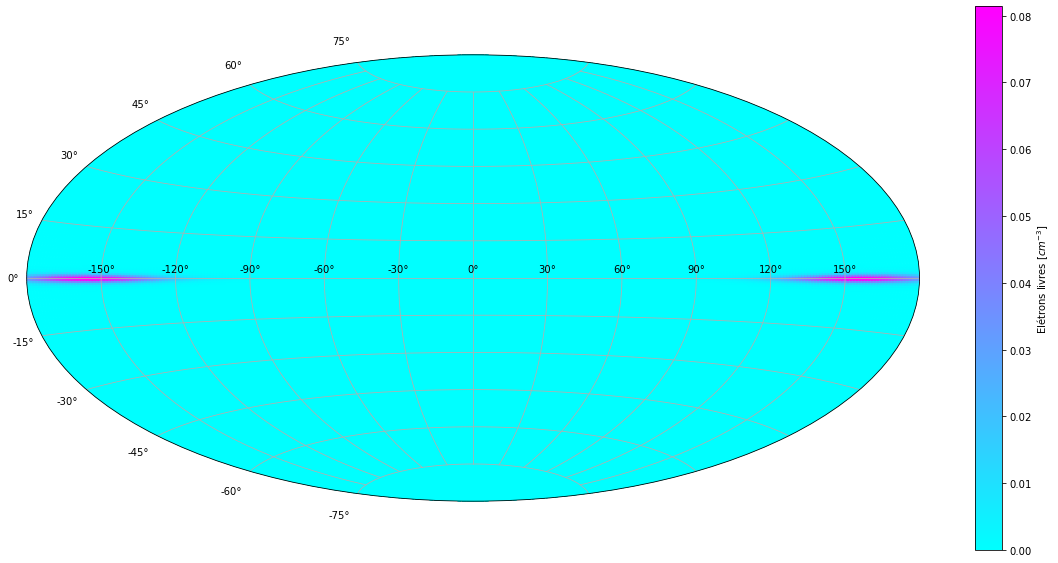

In [5]:
lv,bv = np.meshgrid(angle_l_long, angle_b_lat)
bv,lv = bv.reshape(n*n) * np.pi/180, lv.reshape(n*n) * np.pi/180

plt.figure(figsize=(20, 10))

plt.subplot(111, projection='aitoff')
plt.scatter(lv, bv, c = electrons_free, cmap = 'cool', marker = '.')

plt.colorbar(location='right', label=r'Elétrons livres [$cm^{-3}$]')

plt.grid(True)
plt.show()

### A)

Let's estimate the Emission.

In [6]:
import math
import scipy.integrate as integrate

# --------------- Distance ---------------
def distancias_g(s_radius, l_long, b_lat):

    x, y, z, r = coord_galac(s_radius, l_long, b_lat)

    return np.sqrt((x+2*8.5)**2 + y**2 + z**2)

In [7]:
n2 = 300
angle_l2 = np.linspace(-180, 180, n2)   # in degree
angle_b2 = np.linspace(-90, 90, n2)     # in degree

M_emission = np.zeros([len(angle_b2),len(angle_l2)])

for i in range(len(angle_b2)):
    b = angle_b2[i]
    for j in range(len(angle_l2)):
        l = angle_l2[j]

        dist_max = distancias_g(15, l, b) #diametro da galaxia = 30 kpc
        s = np.arange(0.2,dist_max,0.5)

        prod = np.zeros(len(s))
        for k in range(0,len(s),1):

            prod[k] = np.power(electron_dist(s[k], l, b),2) #in erg * kpc / cm^3 

        M_emission[i][j] = integrate.simps(prod[:], s[:])

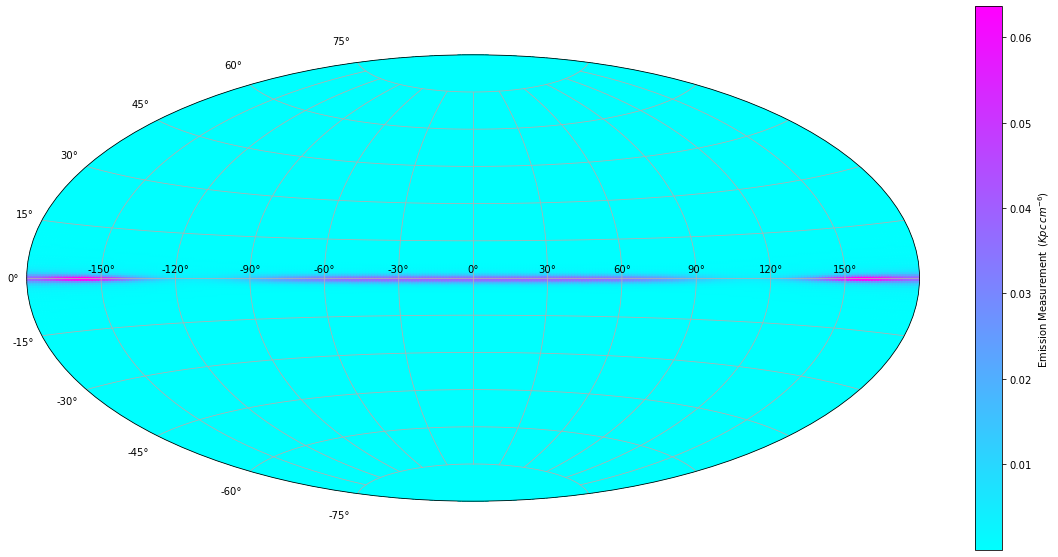

In [8]:
lv2,bv2 = np.meshgrid(angle_l2, angle_b2)

bv2,lv2 = bv2.reshape(n2*n2)*np.pi/180, lv2.reshape(n2*n2)*np.pi/180


plt.figure(figsize=(20, 10))

plt.subplot(111,projection='aitoff')

plt.scatter(lv2, bv2, c = M_emission, cmap='cool', marker='.')
plt.colorbar(location='right', label=r'Emission Measurement $\,  (Kpc \hspace{0.2} cm^{-6})$')

plt.grid(True)
plt.show()

### B)

Let's estimate the Rotation.

In [36]:
const_rot = 2.64e-17 #Gauss^-1
n2 = 50
angle_l2 = np.linspace(-180, -180, n2)    # in degree
angle_l2 = np.concatenate((angle_l2,np.linspace(-180, 180, n2)),axis=None)
angle_b2 = np.linspace(-90, 90, n2)       # in degree
angle_b2 = np.concatenate((angle_b2,np.linspace(-90, 90, n2)),axis=None)

M_RM = np.zeros([len(angle_b2),len(angle_l2)])

for i in range(len(angle_b2)):
    b = angle_b2[i]
    for j in range(len(angle_l2)):
        l = angle_l2[j]

        dist_max = distancias_g(15, l, b) #diametro da galaxia = 30 kpc
        s = np.arange(0.2,dist_max,0.5)

        prod = np.zeros(len(s))
        for k in range(0,len(s),1):

            prod[k] = mag_field(s[k], l, b) * electron_dist(s[k],l,b) * const_rot * 1e-6

        M_RM[i][j] = integrate.simps(prod[:], s[:]) 

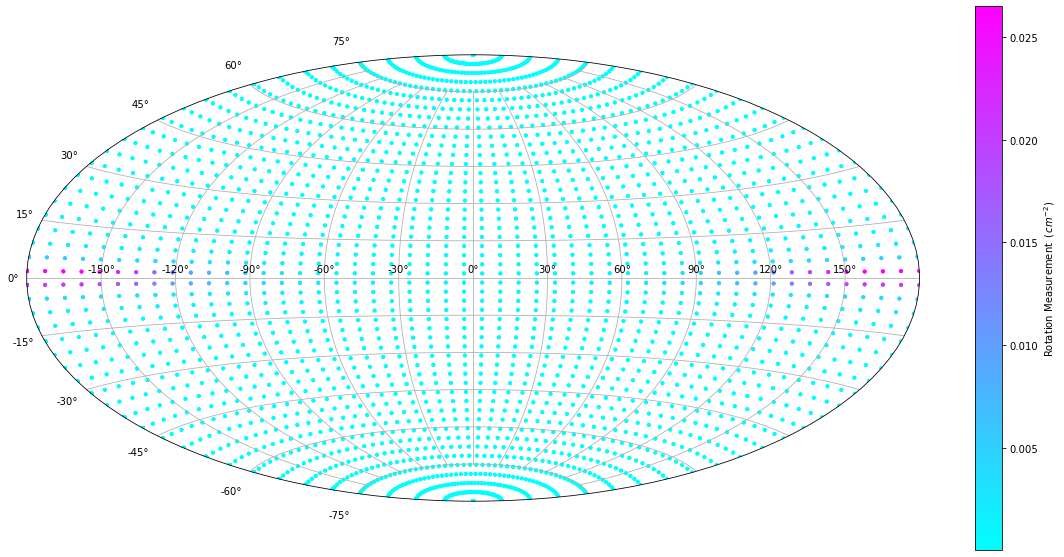

In [37]:
lv2,bv2 = np.meshgrid(angle_l2, angle_b2)

# bv2,lv2 = bv2.reshape(n2*n2)*np.pi/180, lv2.reshape(n2*n2)*np.pi/180
bv2,lv2 = bv2.reshape(100*100)*np.pi/180, lv2.reshape(100*100)*np.pi/180

plt.figure(figsize=(20, 10))

plt.subplot(111,projection='aitoff')

plt.scatter(lv2, bv2, c = M_RM*3.086e21, cmap='cool', marker='.')
plt.colorbar(location='right', label=r'Rotation Measurement $\, (\hspace{0.2} cm^{-2})$')

plt.grid(True)
plt.show()

### C)

Explain how you would modify equations (4-6) from exercise 1' in Listing 06 to take into account the Faraday rotation in the calculation of the Stokes parameters of the Galaxy's Synchrotron emission.

To take into consideration Faraday's rotation, it is necessary to consider the polarization angle variation, according to the photons that cross the magnetic field of the plasma.

The rotation measure is

$$ \frac{\chi}{\lambda^{2}} = RM = \frac{e^{3}}{2 \pi m_{e}^{2} c^{4}} \int_{0}^{L} n_{e} B_{0} ds $$

Which means that the angle variance $\chi $ is

$$ \frac{d \chi}{ds} = c B_{0} n_{e} $$

in which $c$ is a constant and

$$ \left\{\begin{matrix}
\tan{2 \chi} = \frac{U}{Q} \\ 
\\
\cos{2 \chi} = \frac{Q}{P} & \quad ; \quad P = \sqrt{U^{2} + Q^{2}} \\ 
\\
\sin{2 \chi} = \frac{U}{P}
\end{matrix}\right. $$

i.e.

$$ \left\{\begin{matrix}
Q = P \cos{2 \chi} \\ 
\\
U = P \sin{2 \chi}
\end{matrix}\right. $$

Therefore,

$$ \left [\frac{dQ}{ds}  \right ]_{\rm rot} = - P \sin{(2 \chi )}\ 2\frac{d\chi }{ds} = - 2 P \sin{(2 \chi )}\ c\ B_{0}\ n_{e} $$

Similarly,

$$ \left [\frac{dU}{ds}  \right ]_{\rm rot} = - P \cos{(2 \chi )}\ 2\frac{d\chi }{ds} = 2 P \cos{(2 \chi )}\ c\ B_{0}\ n_{e} $$

Hence, we would need to change equations 4-6 of list 6 as

The intensity would remain unchenged:

$$ \frac{dI}{ds} = j_{\rm tot} \quad \rightarrow \quad \frac{dI}{ds} = j_{\rm tot} $$

But Eq. (5) and (6) would change as

$$ \frac{dQ}{ds} = \prod  j_{\rm tot} \cos{(2 \chi)} \quad \rightarrow \quad \frac{dQ}{ds} = \prod  j_{\rm tot} \cos{(2 \chi)} - 2 P \sin{(2 \chi )}\ c\ B_{0}\ n_{e} $$

$$ \frac{dU}{ds} = \prod  j_{\rm tot} \sin{(2 \chi)} \quad \rightarrow \quad \frac{dU}{ds} = \prod  j_{\rm tot} \sin{(2 \chi)} + 2 P \cos{(2 \chi )}\ c\ B_{0}\ n_{e} $$